# Overview
This notebook provides the ability to generate random droplet parameters, write them to disk, and 
train a neural network with said droplet parameters to approximate the underlying ODEs that govern 
the droplet parameters.  Once trained researchers can generate a Fortran 90 module that provides 
the ability to estimate droplet radius and temperature for some time in the future.  

The intent is that a small, reasonably trained neural network can provide accurate enough droplet 
characteristic estimations that are significantly faster than an iterative Gauss-Newton technique.
Initial testing indicates a small 4-layer network (roughly 2400 parameters) with Fortran 90 module
generated by this notebook is 30-90x faster than the existing (as of 2024/09/25) iterative approach 
which results in roughly a factor of 2x overall simulation speedup.

This notebook is broken down into the following sections:

1. ODEs of interest
2. Mapping data to/from $[-1, 1]$
3. Generating random droplets
4. Training a neural network
5. Analyzing a network's performance
6. Exporting a network to Fortran 90



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pandas as pd



from droplet_approximation import *
from droplet_approximation.models import *



In [2]:
model_load_paths = ["../models/network_box_uncoupled_400M_recurrant_l1_epoch_5.pth"]
testing_data_file = "../data/uncoupled_eval_data_stripped.data"

commit_SHA = "4b63260cd37cb84034b405e0939e6ffc791a31d5"


In [3]:
model_count = len(model_load_paths)

model_names = [path.split( "/" )[-1].split( "." )[0] for path in model_load_paths]

models = [ResidualNet() for i in range(model_count)]

for i in range(model_count):
    models[i].load_state_dict( torch.load(model_load_paths[i]))

In [4]:

df = pd.read_parquet("../data/test_particles.parquet")

In [5]:
df

,number observations,birth time,death time,integration times,number be failures,input radii,output radii,input temperatures,output temperatures,salt masses,air temperatures,relative humidities,air densities
particle id,,,,,,,,,,,,,
32,1767.0,2.547703,193.461212,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",1.0,"[2e-07, 2e-07, 7.040546e-07, 1.0435333e-06, 1....","[2e-07, 7.040546e-07, 1.0435333e-06, 1.3147841...","[290.0, 290.19815, 290.50897, 290.50116, 290.4...","[290.19815, 290.50897, 290.50116, 290.497, 290...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[290.19815, 290.1961, 290.1899, 290.18515, 290...","[1.0269803, 1.0270286, 1.0270241, 1.027001, 1....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
33,2248.0,2.547703,226.145462,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 7.690911e-07, 1.1509227e-06, 1.4551285...","[7.690911e-07, 1.1509227e-06, 1.4551285e-06, 1...","[290.0, 290.50232, 290.50827, 290.5072, 290.50...","[290.50232, 290.50827, 290.5072, 290.5049, 290...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[290.1156, 290.12085, 290.11838, 290.11487, 29...","[1.0334499, 1.0335224, 1.0335499, 1.0335798, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
34,1202.0,2.547703,137.542831,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 9.422163e-07, 1.4311536e-06, 1.8179413...","[9.422163e-07, 1.4311536e-06, 1.8179413e-06, 2...","[290.0, 292.22034, 292.19965, 292.20438, 292.2...","[292.22034, 292.19965, 292.20438, 292.20822, 2...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[291.60318, 291.5828, 291.58682, 291.59015, 29...","[1.0515635, 1.0514138, 1.0513583, 1.0513252, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
35,1103.0,2.547703,126.703217,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 8.0835e-07, 1.2150989e-06, 1.5381099e-...","[8.0835e-07, 1.2150989e-06, 1.5381099e-06, 1.8...","[290.0, 290.05463, 290.05203, 290.05255, 290.0...","[290.05463, 290.05203, 290.05255, 290.0529, 29...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[289.61996, 289.61633, 289.61615, 289.616, 289...","[1.0379832, 1.0380492, 1.0380073, 1.0379739, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
36,2662.0,2.547703,270.402130,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 5.588609e-07, 8.003663e-07, 9.947823e-...","[5.588609e-07, 8.003663e-07, 9.947823e-07, 1.1...","[290.0, 289.8356, 289.82626, 289.8246, 289.823...","[289.8356, 289.82626, 289.8246, 289.82373, 289...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[289.6583, 289.65582, 289.65466, 289.6535, 289...","[1.0152293, 1.0152594, 1.0152467, 1.0152352, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,897.0,2.547703,104.024315,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",1.0,"[2e-07, 2e-07, 7.604476e-07, 1.1360195e-06, 1....","[2e-07, 7.604476e-07, 1.1360195e-06, 1.4352302...","[290.0, 290.2547, 290.632, 290.63013, 290.6298...","[290.2547, 290.632, 290.63013, 290.62982, 290....","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[290.2547, 290.2563, 290.25528, 290.25433, 290...","[1.0324576, 1.0323992, 1.0323583, 1.0323207, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
224,1672.0,2.547703,187.265976,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 7.099339e-07, 1.0527015e-06, 1.3263601...","[7.099339e-07, 1.0527015e-06, 1.3263601e-06, 1...","[290.0, 289.97403, 289.97098, 289.97183, 289.9...","[289.97403, 289.97098, 289.97183, 289.97293, 2...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[289.65402, 289.65286, 289.65298, 289.65335, 2...","[1.0279802, 1.0279363, 1.02792, 1.0279104, 1.0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
225,3314.0,2.547703,346.819397,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 8.736594e-07, 1.3201285e-06, 1.6736957...","[8.736594e-07, 1.3201285e-06, 1.6736957e-06, 1...","[290.

In [ ]:
# Calculate NRMSE for each particle
# Perhaps we could write a script to do this en masse on the cluster
nrmse = np.zeros(len(df))
for i in range(len(df)):
    particle_df = df.iloc[i]


    input_parameters = np.stack(particle_df[[
        "input radii",
        "input temperatures",
        "salt masses",
        "air temperatures",
        "relative humidities",
        "air densities"
    ]].to_numpy(), axis=-1)

    times = np.cumsum(particle_df["integration times"])

    model_output = do_iterative_inference(
                            input_parameters, 
                            times,
                            models[0],
                            "cpu"
                        )
    truth_output = do_iterative_bdf(
                            input_parameters, 
                            times,
                            "cpu")
                        

    nrmse[i] = calculate_nrmse( truth_output, model_output, standard_distance  )


/home/dariusc/Documents/Research/Spring_2025_Richter/NTLP/droplet_approximation/python/droplet_approximation/physics.py:340: RuntimeWarning: overflow encountered in cast
  scaled_droplet_parameters[..., 1] = droplet_parameters[..., 1] * (np.diff( DROPLET_TEMPERATURE_RANGE ) / 2) + np.mean( DROPLET_TEMPERATURE_RANGE )
/home/dariusc/Documents/Research/Spring_2025_Richter/NTLP/droplet_approximation/python/droplet_approximation/analysis.py:470: RuntimeWarning: divide by zero encountered in log10
  np.abs( np.log10( model_output[:, 0] / truth_output[:, 0] ) ),
/home/dariusc/Documents/Research/Spring_2025_Richter/NTLP/droplet_approximation/python/droplet_approximation/analysis.py:476: RuntimeWarning: overflow encountered in square
  return np.sqrt( np.mean( distances[:, 0]**2 ) ) / np.abs( np.mean( np.log10 ( truth_output[:, 0] ) ) ) + np.sqrt( np.mean( distances[:, 1]**2 ) ) / np.abs( np.mean( truth_output[:, 1] ) )


IndexError: list index out of range

In [ ]:
df["nrmse"] = nrmse

max:  [4.3385073e-05 2.9852335e+02 2.2116812e-18 2.9875171e+02 1.0725437e+00
 1.0000000e+00]
nrmse:  particle id
46    0.215639
Name: nrmse, dtype: float64
[0.12530851 0.12574434 0.12632823 ... 0.08705139 0.0871582  0.0872345 ]


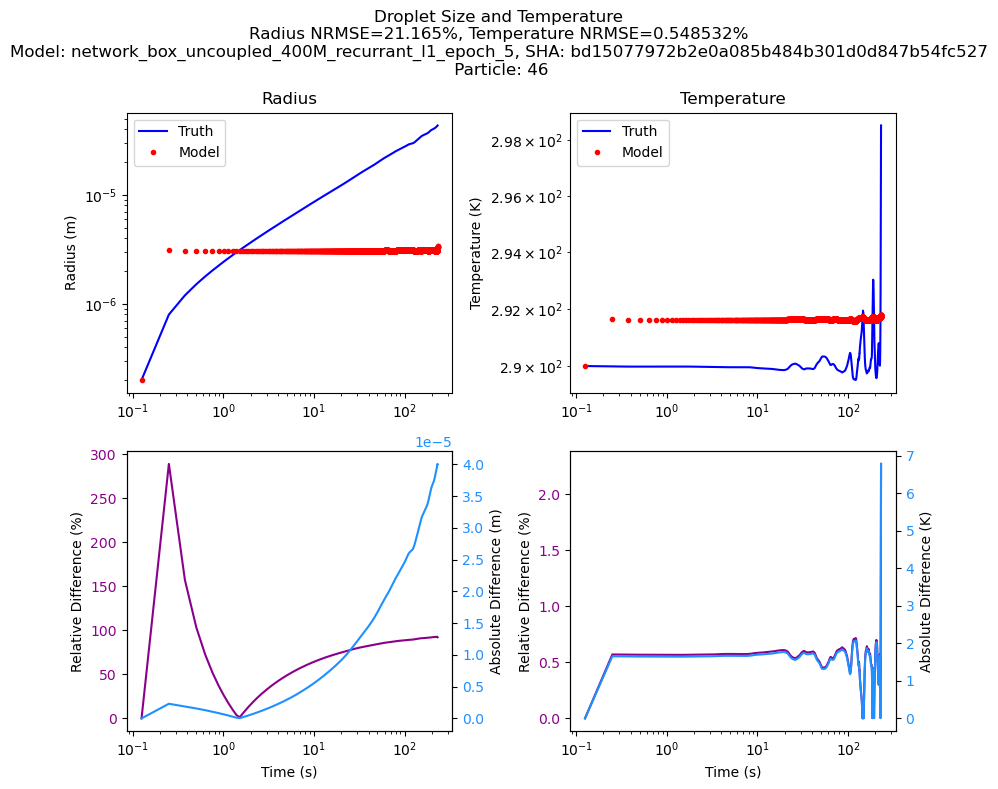

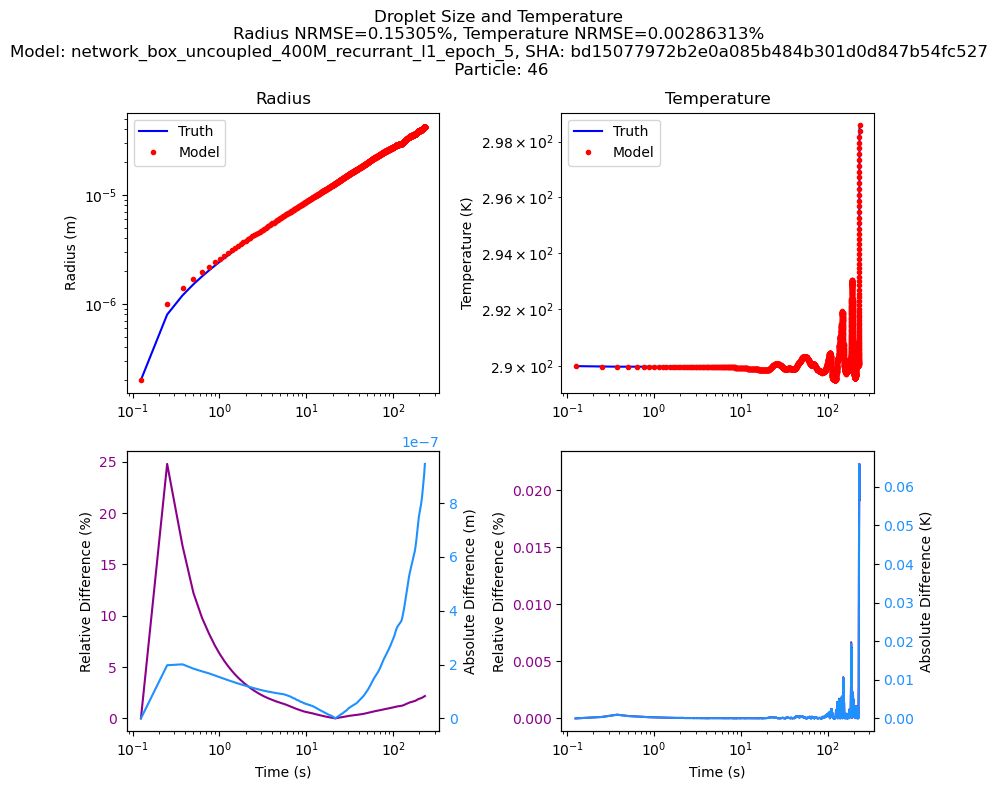

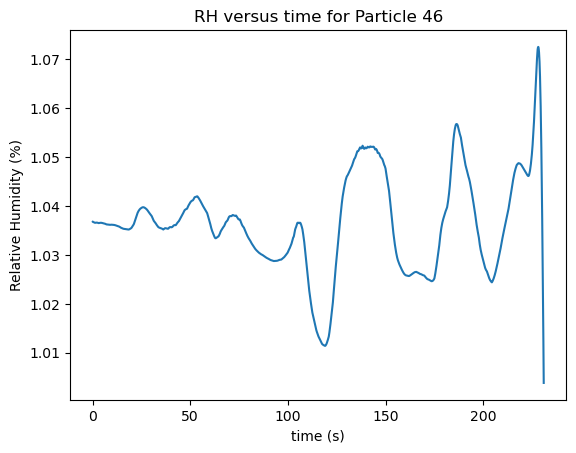

max:  [5.0193441e-05 2.9771255e+02 2.2116812e-18 2.9803891e+02 1.0708027e+00
 1.0000000e+00]
nrmse:  particle id
139    0.22018
Name: nrmse, dtype: float64
[0.12530851 0.12574434 0.12632823 ... 0.11947632 0.11999512 0.12057495]


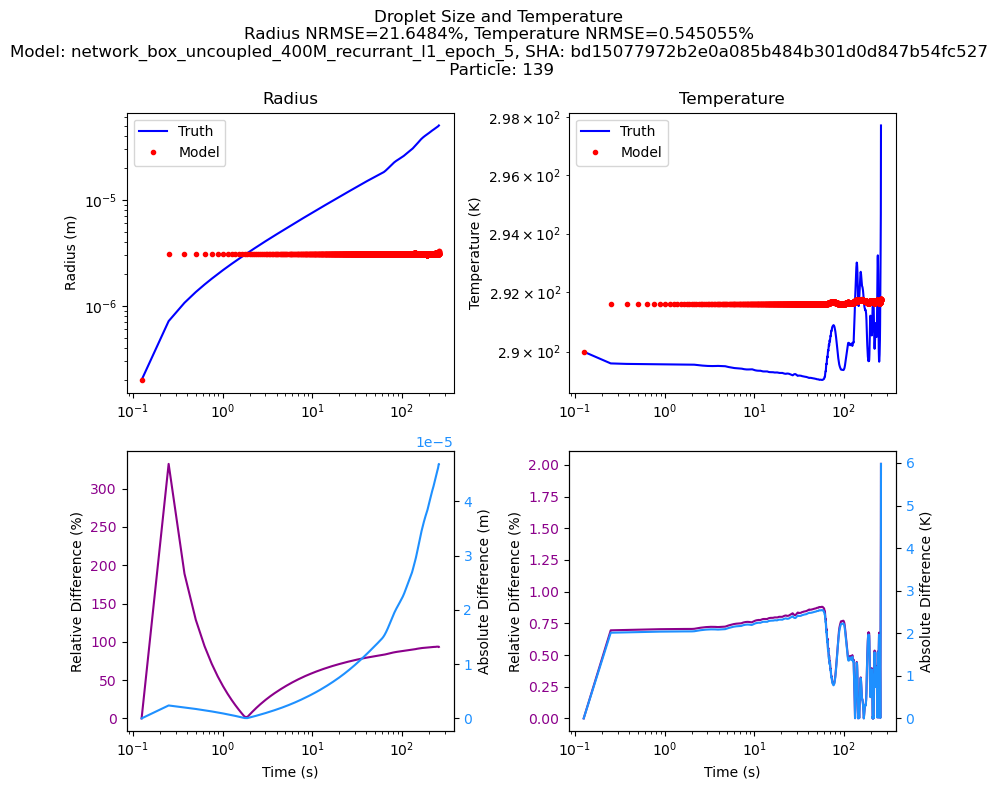

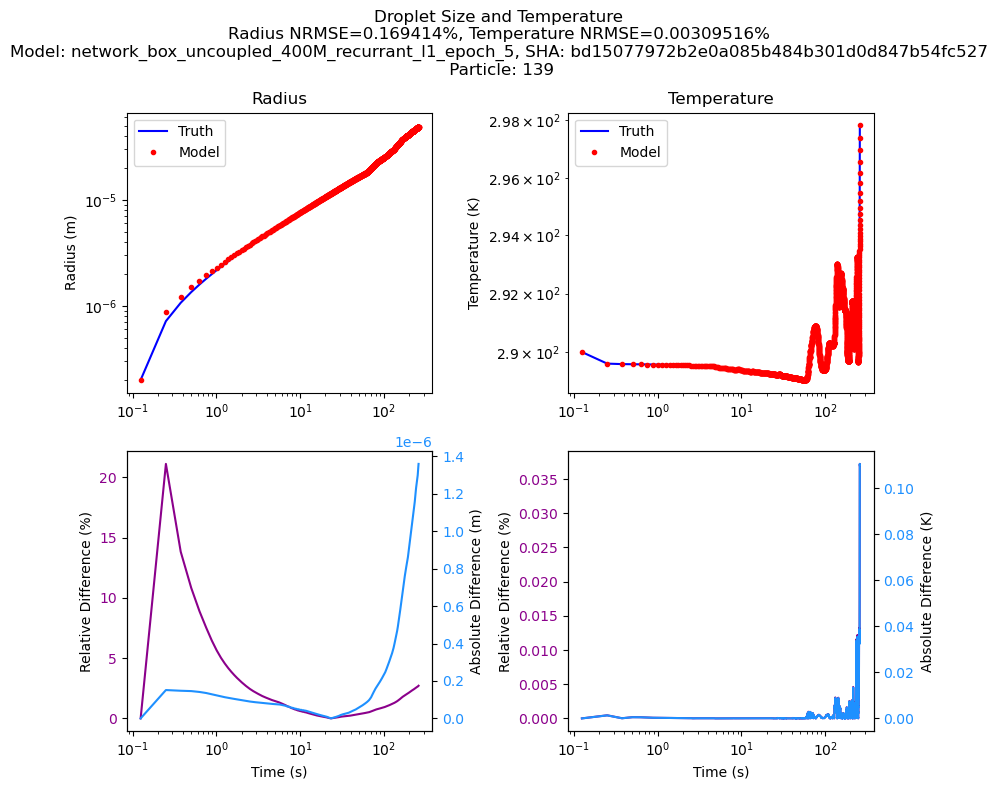

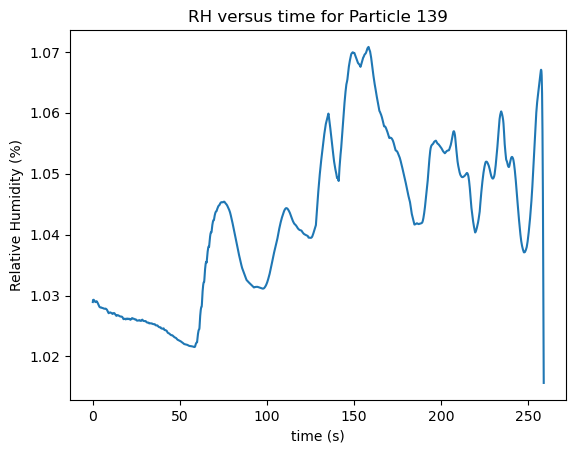

max:  [4.3331100e-05 2.9754230e+02 2.2116812e-18 2.9794650e+02 1.0731859e+00
 1.0000000e+00]
nrmse:  particle id
165    0.214425
Name: nrmse, dtype: float64
[0.12530851 0.12574434 0.12632823 ... 0.08128357 0.08114624 0.08105469]


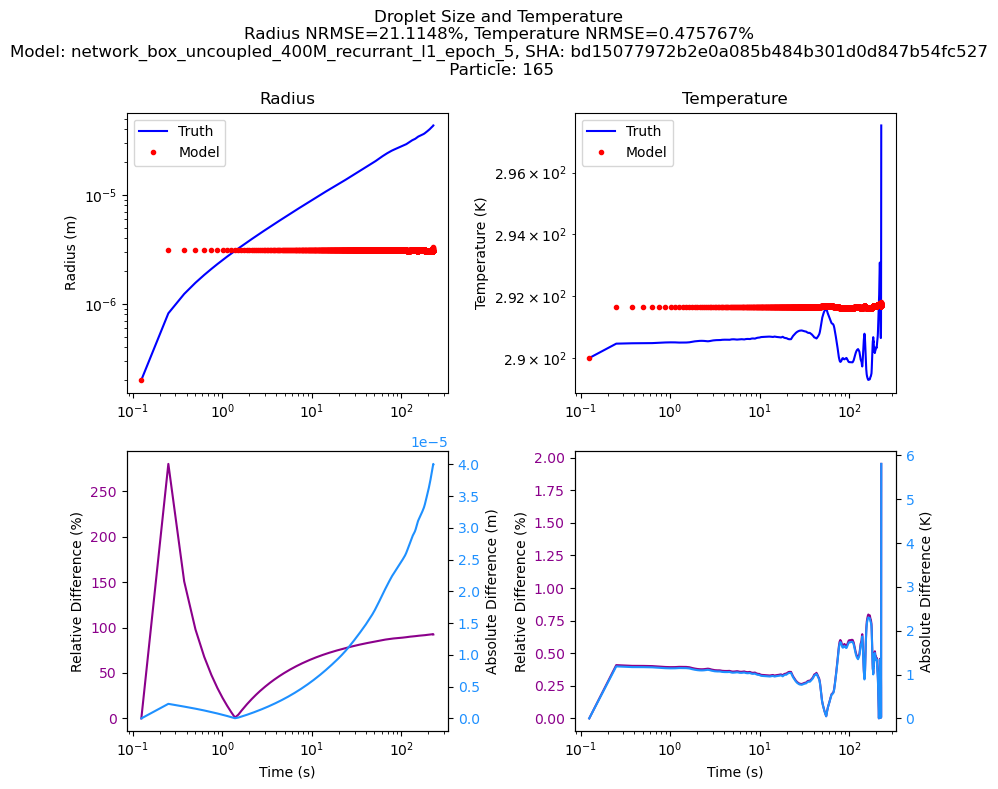

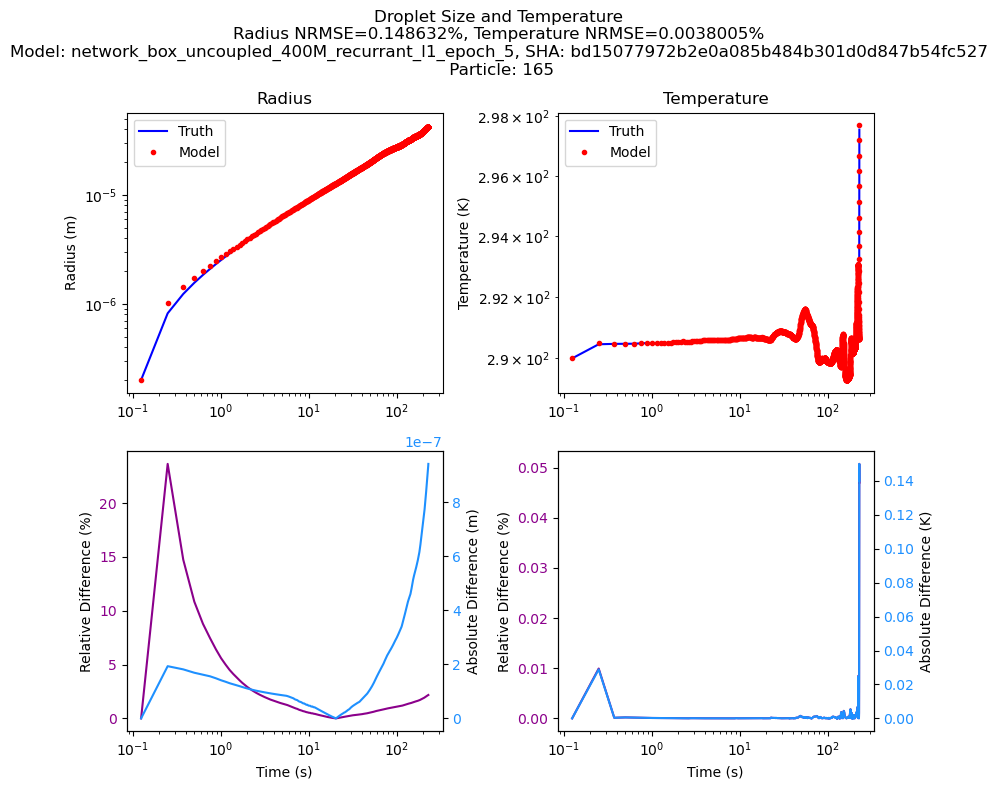

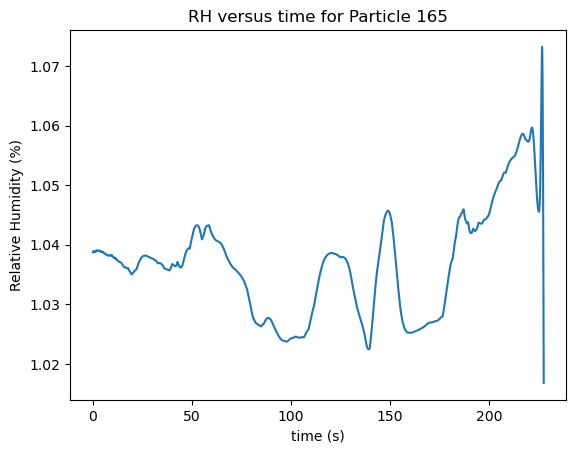

max:  [4.7695747e-05 2.9824136e+02 2.2116812e-18 2.9840567e+02 1.0674051e+00
 1.0000000e+00]
nrmse:  particle id
204    0.217706
Name: nrmse, dtype: float64
[0.12530851 0.12574434 0.12632823 ... 0.08181763 0.08210754 0.08244324]


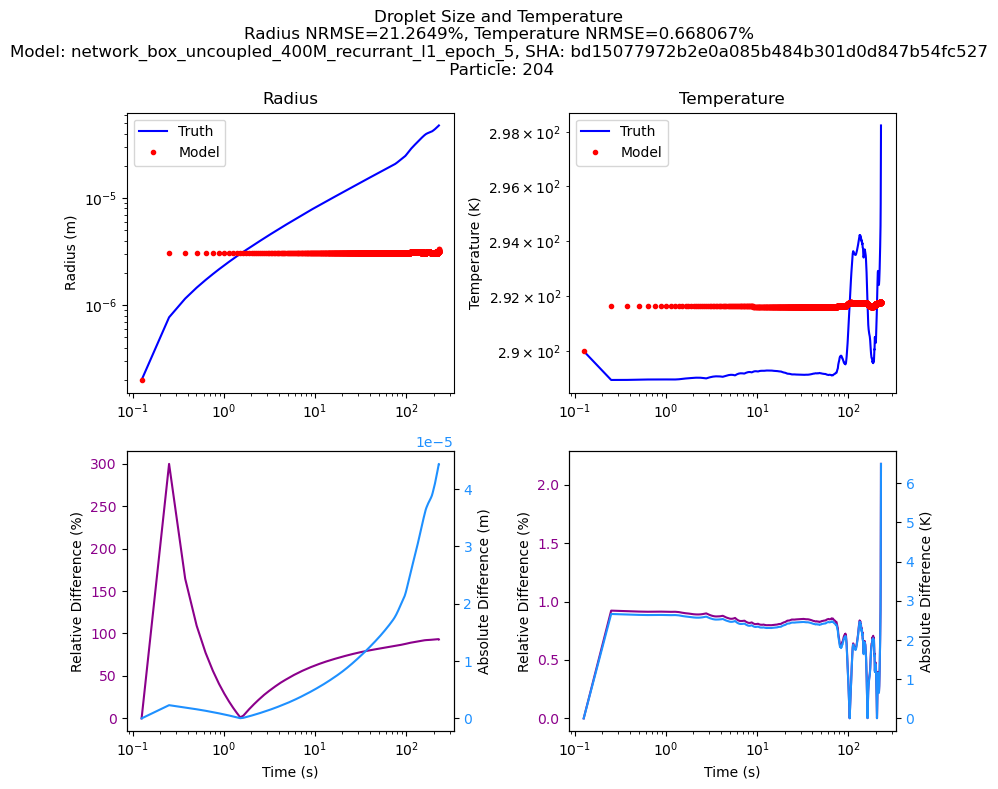

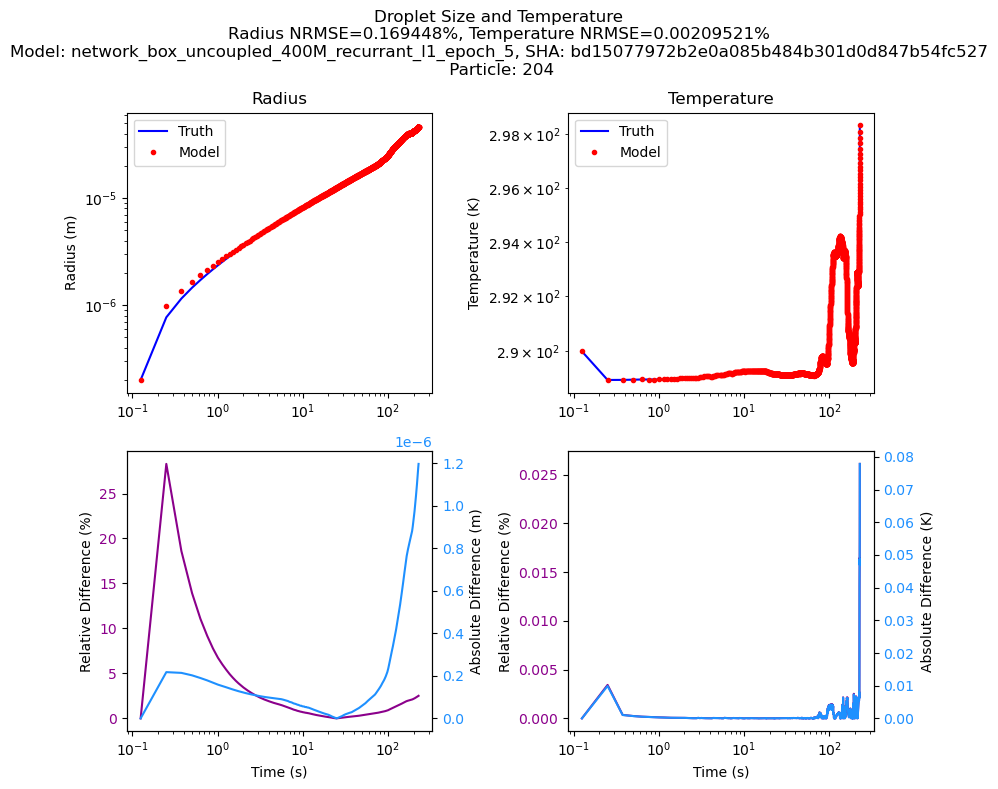

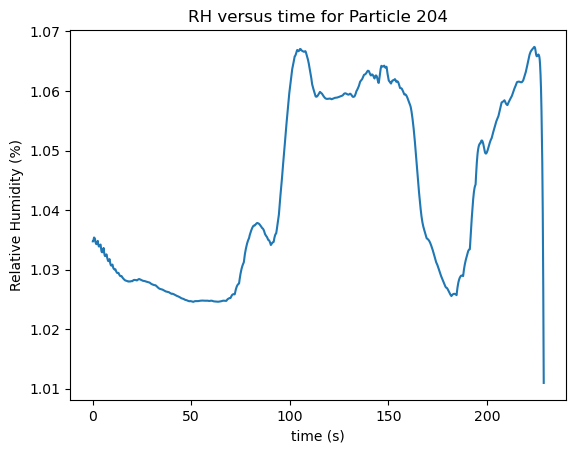

max:  [5.7282861e-05 2.9631543e+02 2.2116812e-18 2.9729352e+02 1.0814471e+00
 1.0000000e+00]
nrmse:  particle id
225    0.233241
Name: nrmse, dtype: float64
[0.12530851 0.12574434 0.12632823 ... 0.12808228 0.12838745 0.12835693]


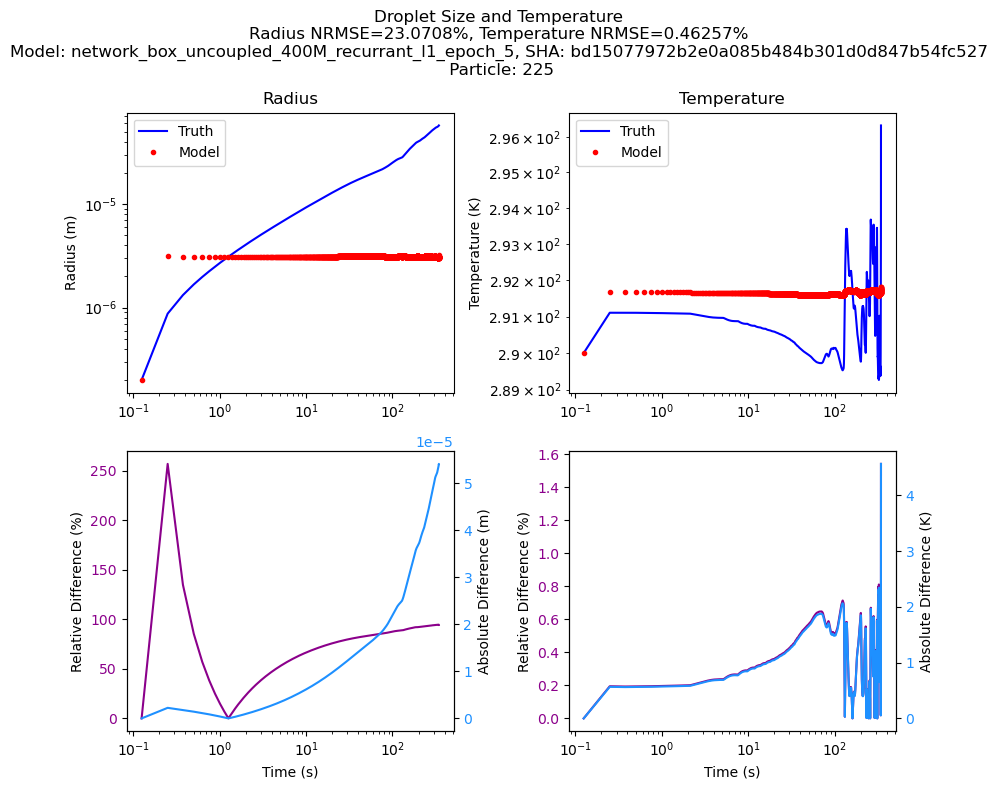

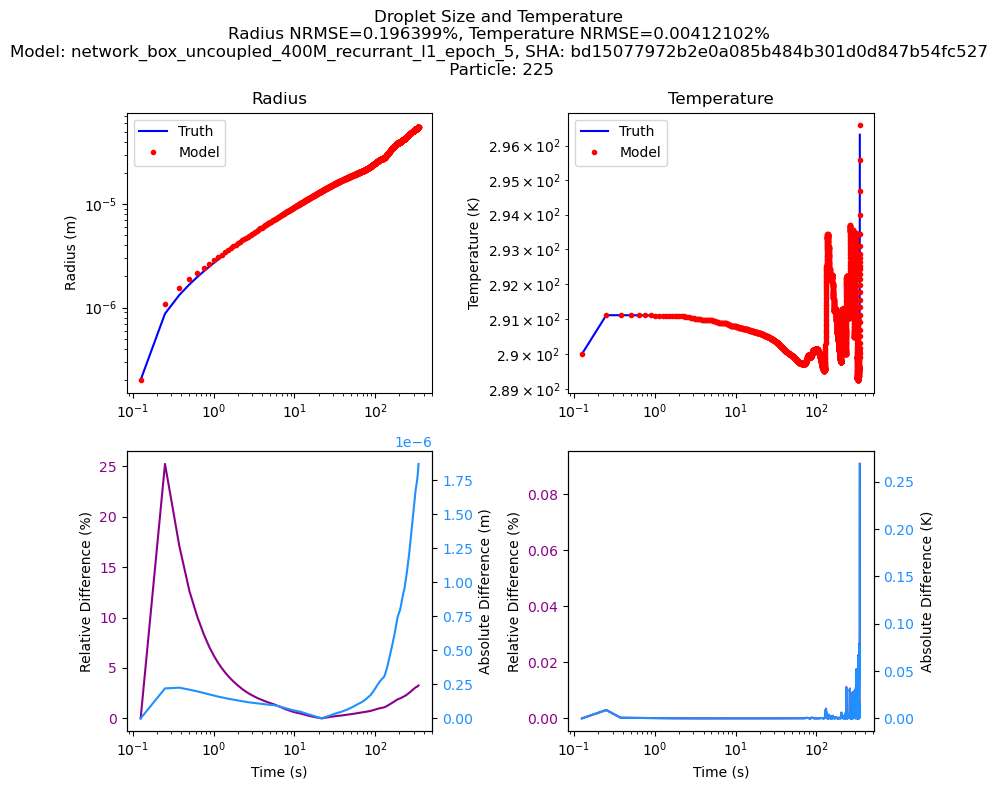

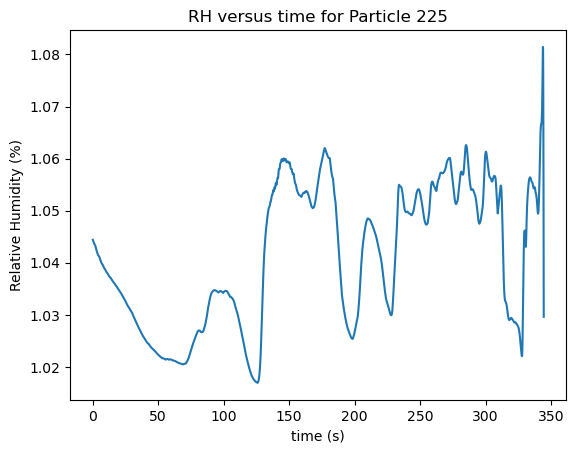

In [ ]:
for i in df[(df["nrmse"] >= df["nrmse"].quantile(.95))].index:
    particle_df = df.loc[df.index == i]
    input_parameters = np.stack(particle_df[[
        "input radii",
        "input temperatures",
        "salt masses",
        "air temperatures",
        "relative humidities",
        "air densities"
    ]].to_numpy()[0], axis=-1)

    print("max: ", input_parameters.max(axis=0))
    print("nrmse: ", particle_df["nrmse"])

    times = np.cumsum(particle_df["integration times"].to_numpy()[0])
    model_outputs = [ do_iterative_inference(
                            input_parameters, 
                            times,
                            models[i],
                            "cpu"
                        ) for i in range( model_count ) ]
    truth_output = do_iterative_bdf(
        input_parameters,
        times,
        "cpu"
    )

    model_distances = [ standard_distance( input_parameters[:, :2], model_outputs[i] ) for i in range( model_count ) ]
    truth_distance = standard_distance( input_parameters[:, :2], truth_output)
    analyze_model_particle_performance(
        times,
        input_parameters[:, :2], 
        truth_output,
        truth_distance,
        "BDF Truth Output, SHA: " + commit_SHA + "\n Particle: " + str( i )
    )
    for i in range( model_count ): 
        analyze_model_particle_performance(
            times,
            input_parameters[:, :2], 
            model_outputs[i],
            model_distances[i],
            "Model: " + model_names[i] + ", SHA: bd15077972b2e0a085b484b301d0d847b54fc527\n Particle: " + str( i )
        )
    plt.figure()
    plt.plot(times, particle_df["relative humidities"].to_numpy()[0])
    plt.title("RH versus time for Particle " + str(i))
    plt.xlabel("time (s)")
    plt.ylabel("Relative Humidity (%)") 
    plt.show()
